In [1]:
%run ../../base-notebook.ipynb

zsh:1: no matches found: ml_*.py
--2023-05-16 12:47:17--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/contents.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444 [text/plain]
Saving to: ‘contents.txt’

contents.txt        100%[===================>]     444  --.-KB/s    in 0s      

2023-05-16 12:47:17 (26.5 MB/s) - ‘contents.txt’ saved [444/444]

--2023-05-16 12:47:18--  https://raw.githubusercontent.com/sodeso-nl/ml-utilities/main/ml_callback.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response.

In [2]:
import sys

sys.path.append("../../ext")

import ext.ml_plot as mlp
import ext.ml_util as mlu

import tensorflow as tf
import keras_tuner as kt
import pandas as pd
import datetime
import shap

from keras import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout
from keras.losses import mean_absolute_error
from keras.callbacks import TensorBoard
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

TensorFlow version: 2.12.0
Python version 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]


## Check if hardware-acceleration is available

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load the insurance-charges dataset

In [4]:
csv_dataframe = pd.read_csv('insurance.csv')
csv_dataframe.head()

,index,age,sex,bmi,children,smoker,region,charges
0,0,19,female,27.900,0,yes,southwest,16884.92400
1,1,18,male,33.770,1,no,southeast,1725.55230
2,2,28,male,33.000,3,no,southeast,4449.46200
3,3,33,male,22.705,0,no,northwest,21984.47061
4,4,32,male,28.880,0,no,northwest,3866.85520


# Check the overal quality of the data

In [5]:
csv_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   index     1338 non-null   int64  
 1   age       1338 non-null   int64  
 2   sex       1338 non-null   object 
 3   bmi       1338 non-null   float64
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 83.8+ KB


In this case we can see that at least all rows have data in each cell since all non-null columns have an equal size (1338).

We do see some interesting columns:
sex: Is an object column containing String values (male / female)
smoker: is an object column containing String values  (True / False)
region: is an object column containing String values

## Chceck the unique values in the region column

In [6]:
csv_dataframe["region"].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

Apparently there are four unique values, we could 1-hot encode them.

## Check the value ranges of each of the columns

In [7]:
csv_dataframe.describe()

,index,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,668.500000,39.207025,30.663397,1.094918,13270.422265
std,386.391641,14.049960,6.098187,1.205493,12110.011237
min,0.000000,18.000000,15.960000,0.000000,1121.873900
25%,334.250000,27.000000,26.296250,0.000000,4740.287150
50%,668.500000,39.000000,30.400000,1.000000,9382.033000
75%,1002.750000,51.000000,34.693750,2.000000,16639.912515
max,1337.000000,64.000000,53.130000,5.000000,63770.428010


We don't see any big-outliers in this case which is great.

## Plot some histograms of the data to see the distribution

array([[<Axes: title={'center': 'index'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'children'}>],
       [<Axes: title={'center': 'charges'}>, <Axes: >]], dtype=object)

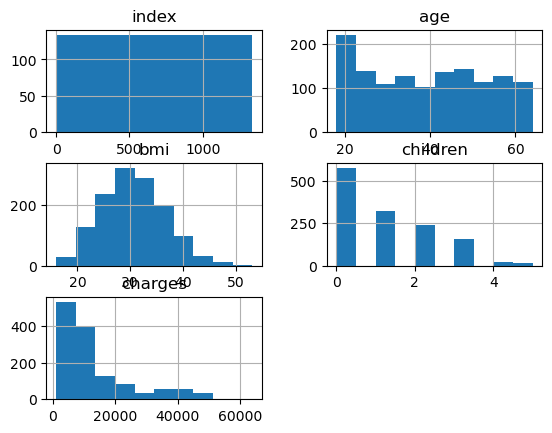

In [8]:
csv_dataframe.hist()

The age columns has a very nice distribution, the BMI has also a nice distribution, no outliers, or high amounts of data on the sides.

## Normalize the data

In [9]:
one_hot_encoder = OneHotEncoder(handle_unknown="ignore")

ct = make_column_transformer(
    (MinMaxScaler(), ["age", "bmi", "children"]),  # turn all values in these columns between 0 and 1
    (one_hot_encoder, ["sex", "smoker", "region"]),
    verbose_feature_names_out=False, # Make sure that the feature names do not have any prefixes from the transformer that created the feature
    verbose=True
)

X = csv_dataframe
y = pd.DataFrame()

y['charges'] = X['charges']
X.drop('charges', axis=1, inplace=True)
X.drop('index', axis=1, inplace=True)

ct.fit(X)

X_norm = ct.transform(X)

[ColumnTransformer] .. (1 of 2) Processing minmaxscaler, total=   0.0s
[ColumnTransformer] . (2 of 2) Processing onehotencoder, total=   0.0s


In [10]:
# Get the feature names after the transformations

feature_labels = ct.get_feature_names_out()

In [11]:
# Visualize the normalized data, column order should be:
# 0: age
# 1: bmi
# 2: Children
# 3 & 4: Sex (One-hot encoded, true / false)
# 5 & 6: Smoker (One-hot encoded, true / false)
# 7, 8, 9  & 10: Region (One-hot encoded, there are 4 regions)

X_norm

array([[0.02173913, 0.3212268 , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.47914985, 0.2       , ..., 0.        , 1.        ,
        0.        ],
       [0.2173913 , 0.45843422, 0.6       , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 0.56201238, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.06521739, 0.26472962, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.93478261, 0.35270379, 0.        , ..., 1.        , 0.        ,
        0.        ]])

## Split the data into train / test data.

In [12]:
X_train, X_test, y_train, y_test = mlu.split_train_test_data(X_norm, y)

print(f"Train data: {len(X_train)}, train labels: {len(y_train)}, Test data {len(X_test)}, Test labels: {len(y_test)}")

Train data: 1070, train labels: 1070, Test data 268, Test labels: 268


## Create model_1 as our baseline model

In [11]:
tf.random.set_seed(42)

learning_rate = 0.01
epochs = 100

model_1 = Sequential([
    Dense(32, input_shape=[11], activation='sigmoid'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1)
])

model_1.compile(loss=mean_absolute_error,
                optimizer=Adam(learning_rate=learning_rate),
                metrics=["mae"])

model_1.summary()

Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 5)                 85        
                                                                 
 dense_4 (Dense)      

In [45]:
history_1 = model_1.fit(x=X_train,
                        y=y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test))

Epoch 1/100
34/34 [==============================] - 1s 15ms/step - loss: 13203.1455 - mae: 13203.1455 - val_loss: 12195.8477 - val_mae: 12195.8477
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 10173.5010 - mae: 10173.5000 - val_loss: 8890.2852 - val_mae: 8890.2852
Epoch 3/100
34/34 [==============================] - 0s 10ms/step - loss: 8409.1543 - mae: 8409.1543 - val_loss: 8527.1152 - val_mae: 8527.1152
Epoch 4/100
34/34 [==============================] - 0s 10ms/step - loss: 7975.4922 - mae: 7975.4922 - val_loss: 7636.2168 - val_mae: 7636.2168
Epoch 5/100
34/34 [==============================] - 0s 10ms/step - loss: 6428.7939 - mae: 6428.7939 - val_loss: 4714.7227 - val_mae: 4714.7227
Epoch 6/100
34/34 [==============================] - 0s 10ms/step - loss: 4685.6128 - mae: 4685.6123 - val_loss: 3868.8696 - val_mae: 3868.8696
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 4306.8271 - mae: 4306.8271 - val_loss: 3424.8455 - val_mae

In [49]:
model_1.evaluate(X_test, y_test)

9/9 [==============================] - 0s 5ms/step - loss: 2807.2195 - mae: 2807.2195


[2807.219482421875, 2807.219482421875]

In [50]:
y_train.median(), y_train.mean()

(charges    9575.4421
 dtype: float64,
 charges    13346.089736
 dtype: float64)

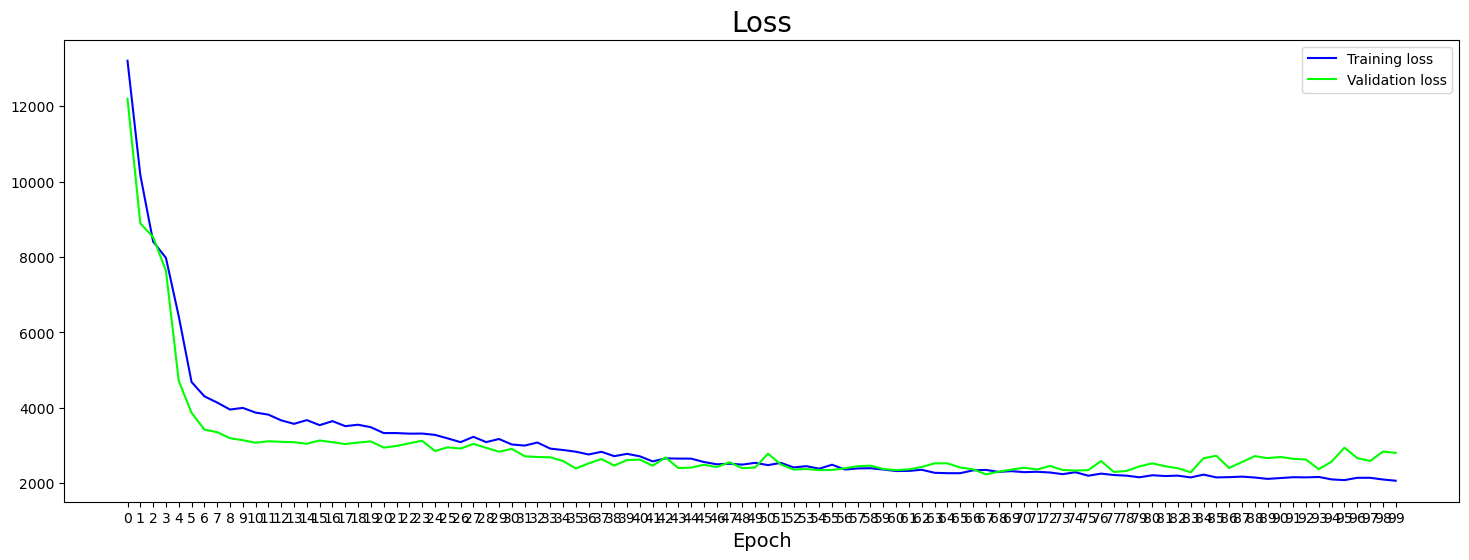

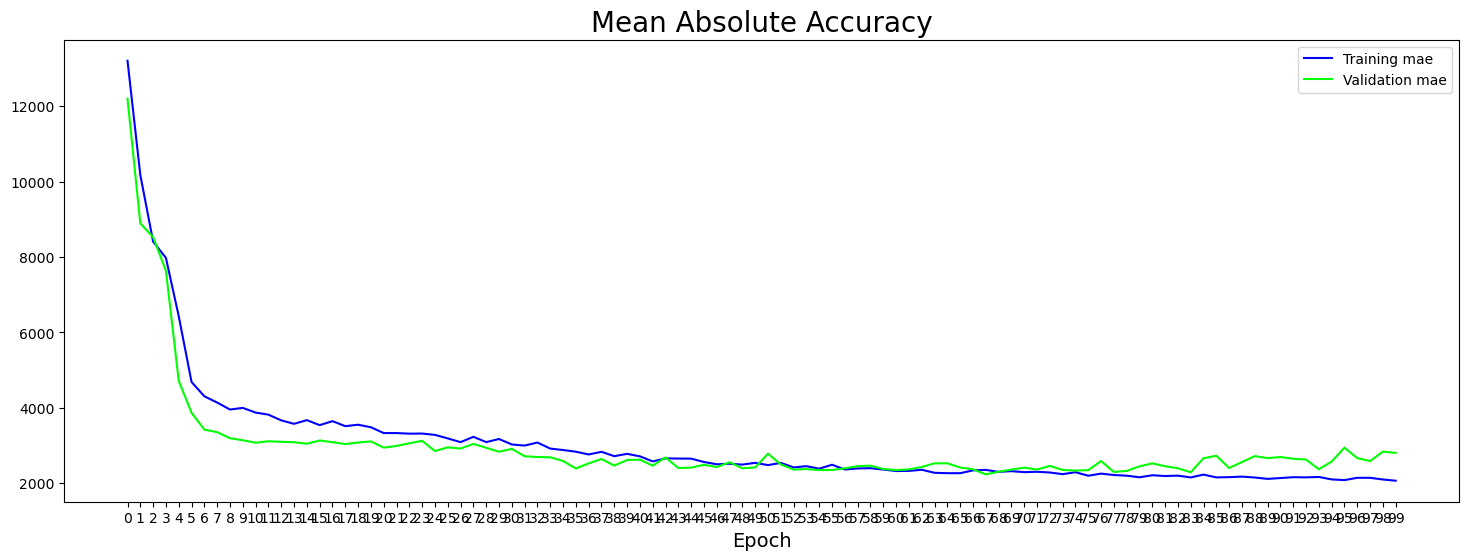

In [51]:
mlp.plot_history(history=history_1, figsize=(18, 6))

## Create model_2 with the new learning rate

In [52]:
tf.random.set_seed(42)

model_2 = Sequential([
    Dense(32, input_shape=[11], activation='sigmoid'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1)
])

model_2.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 32)                384       
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_56 (Dense)            (None, 32)                1056      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_57 (Dense)            (None, 32)                1056      
                                                                 
 dense_58 (Dense)            (None, 5)                 165       
                                                                 
 dense_59 (Dense)            (None, 1)               

In [53]:
model_2.compile(loss=mean_absolute_error,
                optimizer=Adam(learning_rate=0.02),
                metrics=["mae"])

history_2 = model_2.fit(X_train,
                        y_train,
                        epochs=100,
                        validation_data=(X_test, y_test))

Epoch 1/100
34/34 [==============================] - 1s 15ms/step - loss: 11941.4170 - mae: 11941.4170 - val_loss: 8894.3887 - val_mae: 8894.3887
Epoch 2/100
34/34 [==============================] - 0s 8ms/step - loss: 8545.7480 - mae: 8545.7480 - val_loss: 8315.9746 - val_mae: 8315.9746
Epoch 3/100
34/34 [==============================] - 0s 8ms/step - loss: 6962.2227 - mae: 6962.2227 - val_loss: 4644.0728 - val_mae: 4644.0728
Epoch 4/100
34/34 [==============================] - 0s 8ms/step - loss: 4715.4453 - mae: 4715.4453 - val_loss: 3596.2244 - val_mae: 3596.2244
Epoch 5/100
34/34 [==============================] - 0s 8ms/step - loss: 4167.2305 - mae: 4167.2305 - val_loss: 3418.3840 - val_mae: 3418.3840
Epoch 6/100
34/34 [==============================] - 0s 8ms/step - loss: 3917.4932 - mae: 3917.4932 - val_loss: 3136.3962 - val_mae: 3136.3962
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 3840.3354 - mae: 3840.3354 - val_loss: 3067.7490 - val_mae: 3067.7

In [54]:
model_2.evaluate(X_test, y_test)

9/9 [==============================] - 0s 4ms/step - loss: 2626.1230 - mae: 2626.1230


[2626.123046875, 2626.123046875]

In [55]:
y_train.median(), y_train.mean()

(charges    9575.4421
 dtype: float64,
 charges    13346.089736
 dtype: float64)

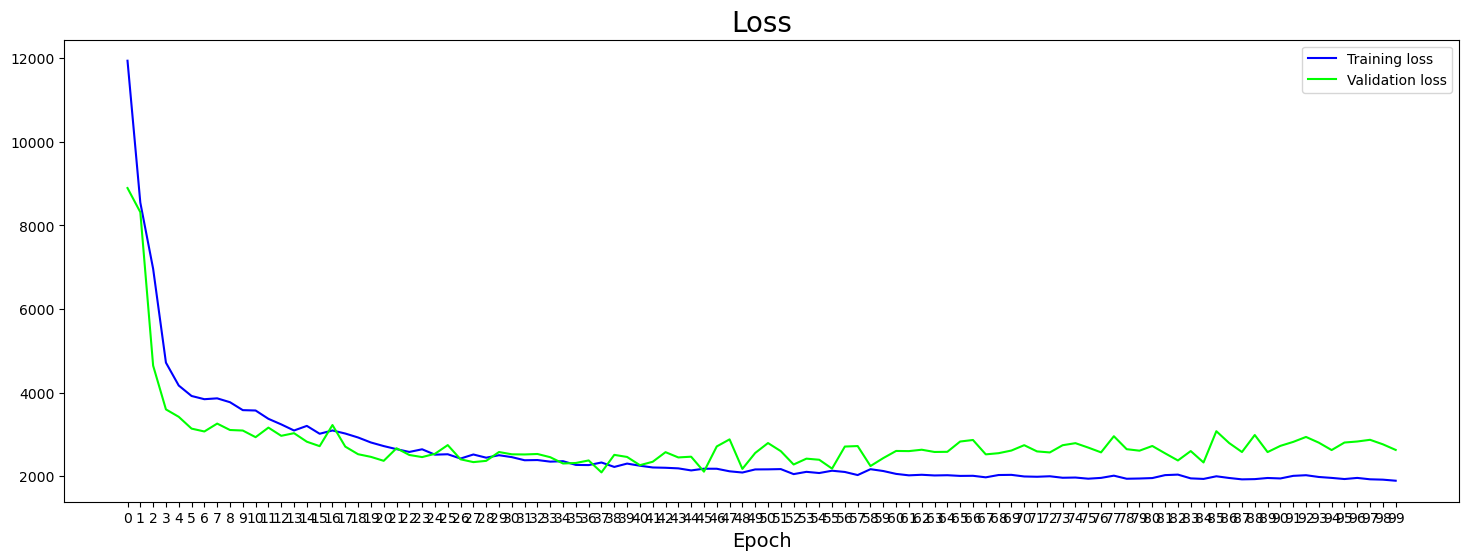

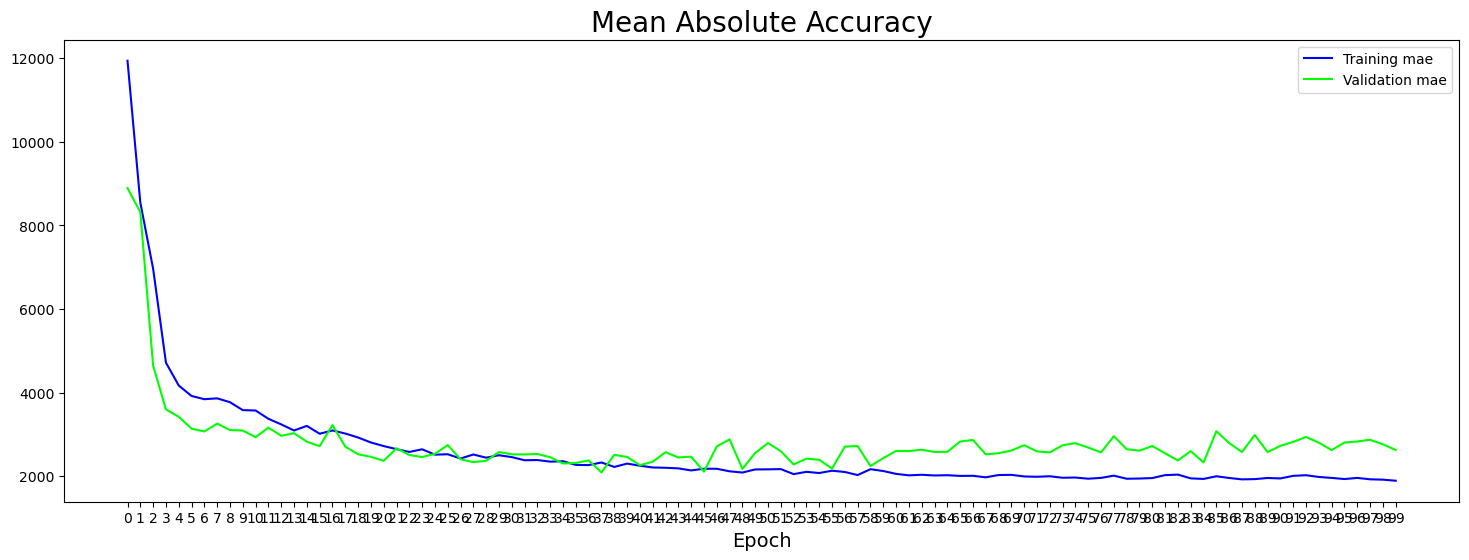

In [56]:
mlp.plot_history(history=history_2, figsize=(18, 6))

## Plot some of the columns as a histogram

<Axes: ylabel='Frequency'>

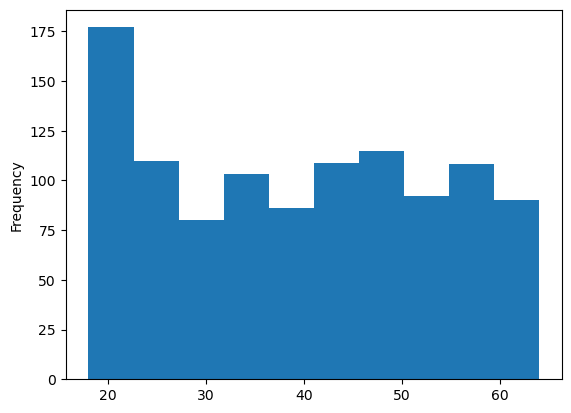

In [53]:
X_train["age"].plot(kind="hist")

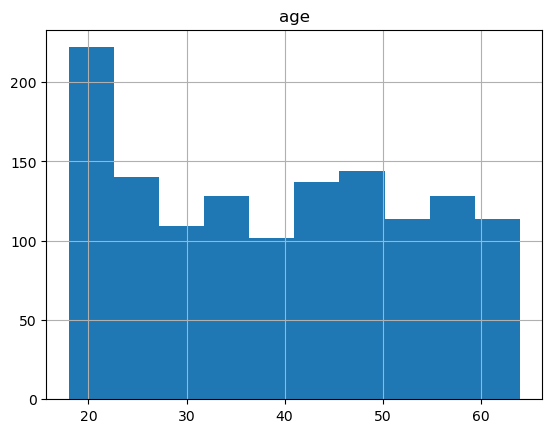

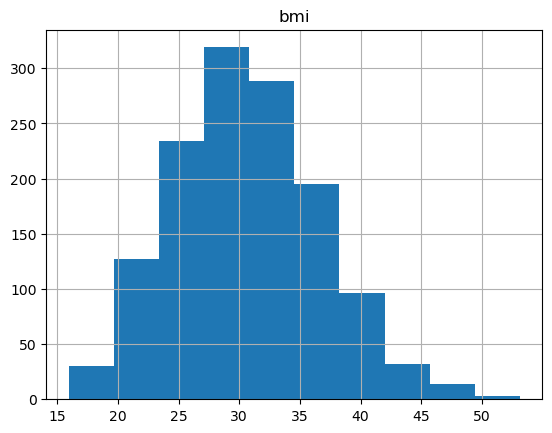

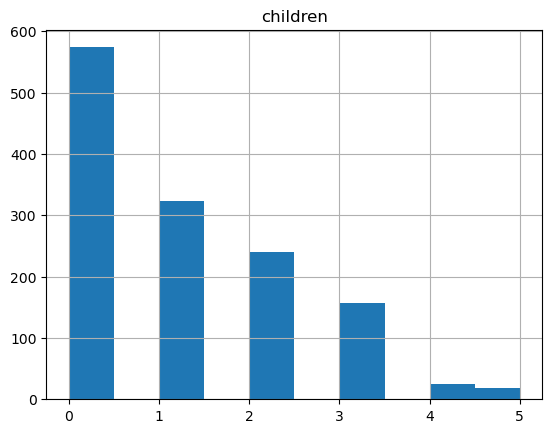

In [66]:
mlp.plot_histogram_from_dataframe(X, ["age", "bmi", "children"])

## Let's try TensorBoard in combination with a number of model

In [14]:
neuron_sizes = [10, 16, 32, 48, 64]
dropout_percentages = [0.10, 0.15, 0.20, 0.25]

for neurons in neuron_sizes:
    for dropout_percentage in dropout_percentages:
        tf.random.set_seed(42)

        model_gen = Sequential([
            Dense(neurons, input_shape=[11], activation='sigmoid'),
            Dropout(dropout_percentage),
            Dense(neurons, activation='relu'),
            Dropout(dropout_percentage),
            Dense(neurons, activation='relu'),
            Dense(5, activation='relu'),
            Dense(1)
        ])

        model_gen.summary()

        model_gen.compile(loss=mean_absolute_error,
                          optimizer=Adam(learning_rate=0.02),
                          metrics=["mae"])

        log_dir = f"logs/neurons-{neurons}-dropout-{dropout_percentage * 10}-" + datetime.datetime.now().strftime(
            "%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        history_geb = model_gen.fit(X_train,
                                    y_train,
                                    epochs=100,
                                    validation_data=(X_test, y_test),
                                    callbacks=[tensorboard_callback])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 10)                120       
                                                                 
 dropout_12 (Dropout)        (None, 10)                0         
                                                                 
 dense_31 (Dense)            (None, 10)                110       
                                                                 
 dropout_13 (Dropout)        (None, 10)                0         
                                                                 
 dense_32 (Dense)            (None, 10)                110       
                                                                 
 dense_33 (Dense)            (None, 5)                 55        
                                                                 
 dense_34 (Dense)            (None, 1)                

## Start TensorBoard to look at the results

Start tensorboard by executing the command:

python3 -m tensorboard.main --logdir=./logs

Do not forget to activate your conda environment:

conda activate kaggle-insurance-charges

## Try the best performing model from TensorBoard

In [17]:
tf.random.set_seed(42)

model_best = Sequential([
    Dense(48, input_shape=[11], activation='sigmoid'),
    Dropout(0.2),
    Dense(48, activation='relu'),
    Dropout(0.2),
    Dense(48, activation='relu'),
    Dense(5, activation='relu'),
    Dense(1)
])

model_best.summary()

model_best.compile(loss=mean_absolute_error,
                  optimizer=Adam(learning_rate=0.02),
                  metrics=["mae"])

history_best = model_best.fit(X_train,
                            y_train,
                            epochs=100,
                            validation_data=(X_test, y_test))

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_131 (Dense)           (None, 48)                576       
                                                                 
 dropout_53 (Dropout)        (None, 48)                0         
                                                                 
 dense_132 (Dense)           (None, 48)                2352      
                                                                 
 dropout_54 (Dropout)        (None, 48)                0         
                                                                 
 dense_133 (Dense)           (None, 48)                2352      
                                                                 
 dense_134 (Dense)           (None, 5)                 245       
                                                                 
 dense_135 (Dense)           (None, 1)               

In [18]:
model_best.evaluate(X_test, y_test)

9/9 [==============================] - 0s 5ms/step - loss: 1791.6075 - mae: 1791.6075


[1791.6075439453125, 1791.6075439453125]

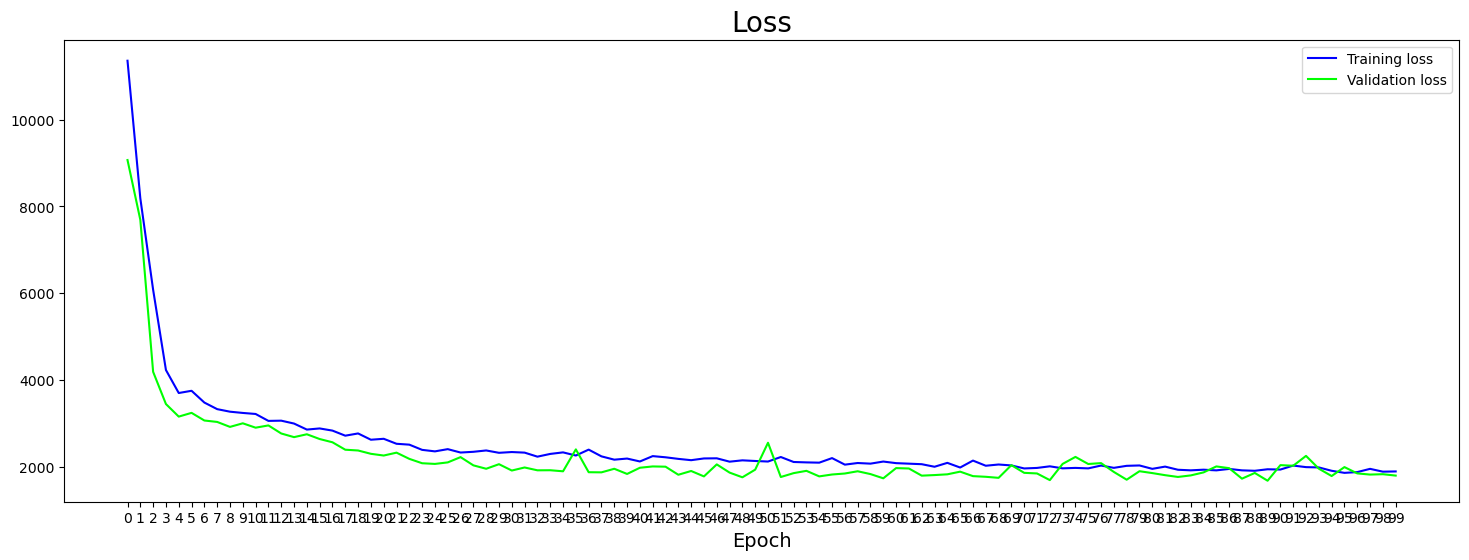

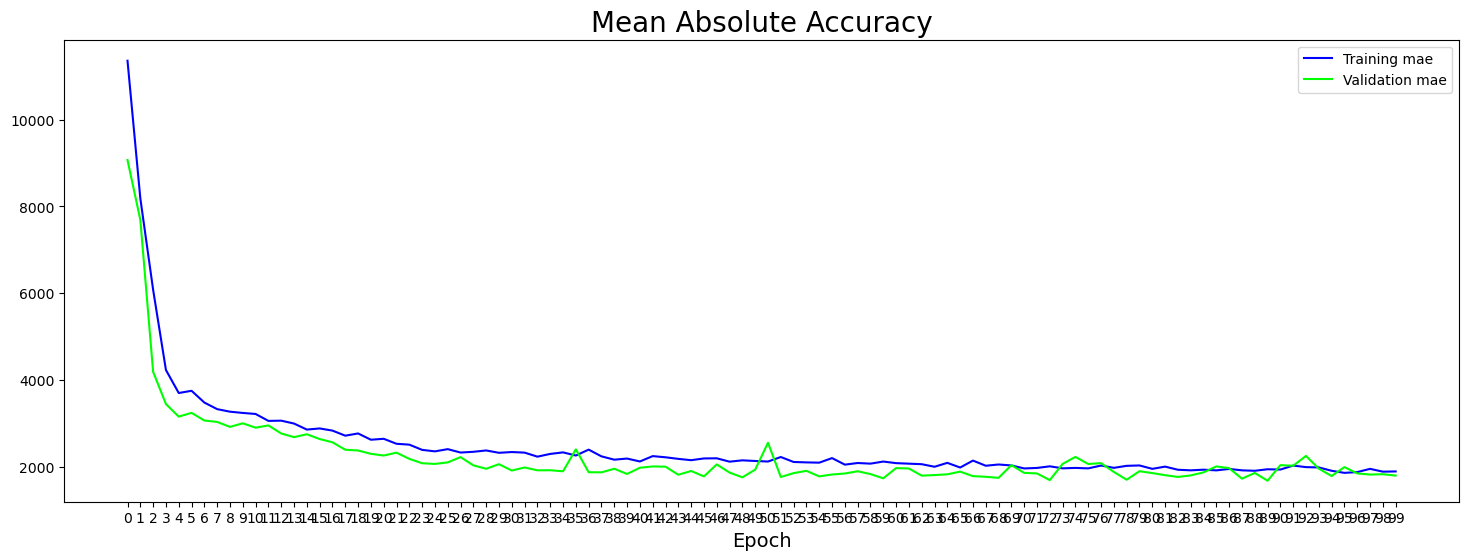

In [21]:
mlp.plot_history(history=history_best, figsize=(18, 6))

## Let's try to use the Keras Tuner and see what the results are

In [30]:
# Create a model containing variables for each of the parameters and use the Keras Tuner to find the optimal model.

tf.random.set_seed(42)

def model_builder(hp):
    hp_units_dense_1 = hp.Int('dense_1_units', min_value=16, max_value=64, step=16)
    hp_units_dense_2 = hp.Int('dense_2_units', min_value=16, max_value=64, step=16)
    hp_units_dense_3 = hp.Int('dense_3_units', min_value=16, max_value=64, step=16)
    hp_units_dense_4 = hp.Int('dense_4_units', min_value=16, max_value=64, step=16)
    hp_rate_dropout_1 = hp.Choice('dropout_1_rate', values=[0.1, 0.2])
    hp_rate_dropout_2 = hp.Choice('dropout_2_rate', values=[0.1, 0.2])

    model_kt = Sequential([
        Dense(name="Dense_1", units=hp_units_dense_1, input_shape=[11], activation='sigmoid'),
        Dropout(name="Dropout_1", rate=hp_rate_dropout_1),
        Dense(name="Dense_2", units=hp_units_dense_2, activation='relu'),
        Dropout(name="Dropout_2", rate=hp_rate_dropout_2),
        Dense(name="Dense_3", units=hp_units_dense_3, activation='relu'),
        Dense(name="Dense_4", units=hp_units_dense_4, activation='relu'),
        Dense(1)
    ])

    model_kt.summary()

    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01, 0.015, 0.02])

    model_kt.compile(loss=mean_absolute_error,
                      optimizer=Adam(learning_rate=hp_learning_rate),
                      metrics=["mae"])

    return model_kt

In [31]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner = kt.Hyperband(model_builder,
                     objective='mae',
                     max_epochs=50,
                     factor=3,
                     directory='tuner',
                     project_name='kaggle-insurance-charges')

tuner.search(X_train,
             y_train,
             validation_data=(X_test, y_test),
             epochs=100,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps

Trial 90 Complete [00h 00m 19s]
mae: 3877.536376953125

Best mae So Far: 2156.709228515625
Total elapsed time: 00h 07m 02s
INFO:tensorflow:Oracle triggered exit


In [45]:
# Display the best found parameters
best_hps.values

{'dense_1_units': 48,
 'dense_2_units': 32,
 'dense_3_units': 64,
 'dense_4_units': 16,
 'dropout_1_rate': 0.2,
 'dropout_2_rate': 0.1,
 'learning_rate': 0.02,
 'tuner/epochs': 50,
 'tuner/initial_epoch': 17,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0067'}

In [13]:
# Try out the best parameters (in this case it is a different set found before)
tf.random.set_seed(42)

model_best_tuner = Sequential([
    Dense(64, input_shape=[11], activation='sigmoid'),
    Dropout(0.2),
    Dense(48, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model_best_tuner.summary()

model_best_tuner.compile(loss=mean_absolute_error,
                  optimizer=Adam(learning_rate=0.02),
                  metrics=["mae"])

history_best_tuner = model_best_tuner.fit(X_train,
                            y_train,
                            epochs=100,
                            validation_data=(X_test, y_test))

Metal device set to: Apple M1 Max
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 48)                3120      
                                                                 
 dropout_1 (Dropout)         (None, 48)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                784       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)      

2023-05-01 14:40:41.871111: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


34/34 [==============================] - 1s 16ms/step - loss: 11702.2383 - mae: 11702.2383 - val_loss: 9372.8184 - val_mae: 9372.8184
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 8227.5986 - mae: 8227.5986 - val_loss: 7880.7788 - val_mae: 7880.7788
Epoch 3/100
34/34 [==============================] - 0s 9ms/step - loss: 6249.2710 - mae: 6249.2710 - val_loss: 4309.2715 - val_mae: 4309.2715
Epoch 4/100
34/34 [==============================] - 0s 9ms/step - loss: 4236.7891 - mae: 4236.7891 - val_loss: 3413.3110 - val_mae: 3413.3110
Epoch 5/100
34/34 [==============================] - 0s 9ms/step - loss: 3700.1711 - mae: 3700.1711 - val_loss: 3082.9451 - val_mae: 3082.9451
Epoch 6/100
34/34 [==============================] - 0s 9ms/step - loss: 3646.6365 - mae: 3646.6365 - val_loss: 3133.0569 - val_mae: 3133.0569
Epoch 7/100
34/34 [==============================] - 0s 10ms/step - loss: 3533.7729 - mae: 3533.7729 - val_loss: 3079.0979 - val_mae: 3079.0979
Epoch 8

In [65]:
model_best_tuner.evaluate(X_test, y_test)

9/9 [==============================] - 0s 6ms/step - loss: 1959.9711 - mae: 1959.9711


[1959.9710693359375, 1959.9710693359375]

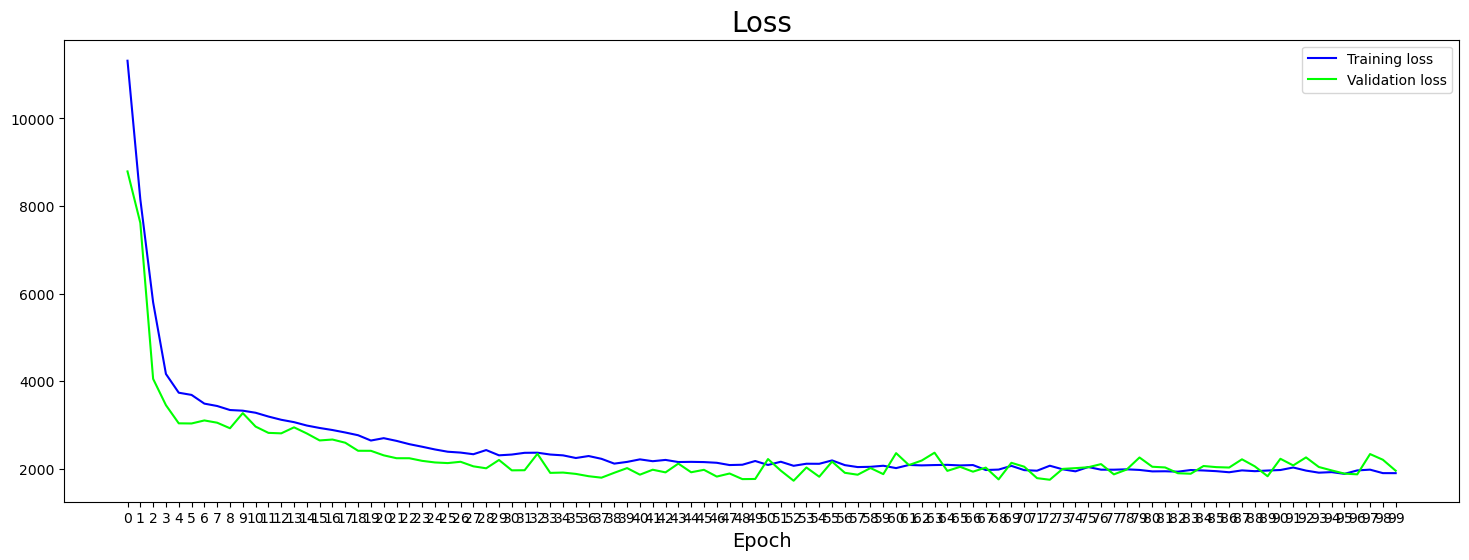

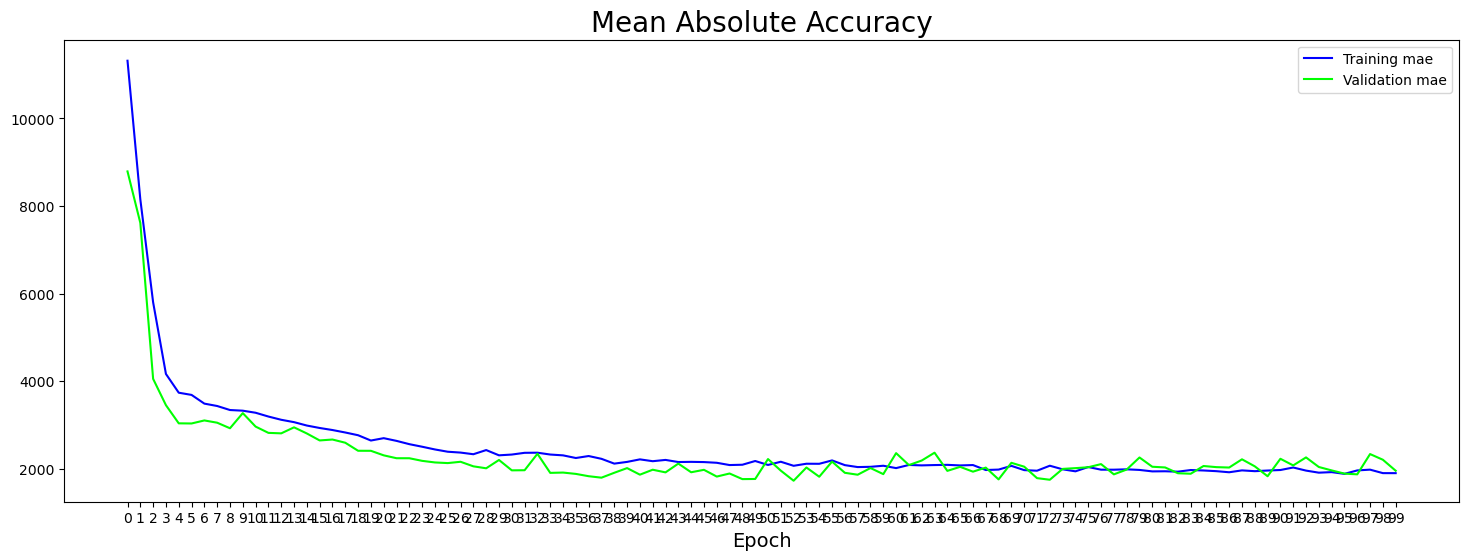

In [66]:
mlp.plot_history(history=history_best_tuner, figsize=(18, 6))

## Display SHAP important feature columns

https://www.kirenz.com/post/2022-06-17-explainable-ai-with-tensorflow-keras-and-shap/

Nice documentation and explanation:

https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#Explaining-a-linear-regression-model

## Setup shap explainer and values

In [57]:
explainer = shap.KernelExplainer(model_best_tuner, X_train[:50,:])
shap_values = explainer.shap_values(X_train[20,:], nsamples=500)

## Explain single prediction

The so called force plot below shows how each feature contributes to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue. To learn more about force plots, take a look at this Nature BME paper from Lundberg et al. (2018).



In [60]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train[20,:], feature_names=feature_labels)

## Explain many predictions

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (see content below). Here, we repeat the above explanation process for 50 individuals.

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature’s responsibility for a change in the model output, the plot below represents the change in the dependent variable. Vertical dispersion at a single value of represents interaction effects with other features.

In [37]:
shap_values50 = explainer.shap_values(X_train[50:100,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values50[0], X_train[50:100,:], feature_names=feature_labels)

  0%|          | 0/50 [00:00<?, ?it/s]